In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
from pathlib import Path
import pandas as pd

DATASET_PATH = Path("data/processed/dataset.csv")

df = pd.read_csv(DATASET_PATH)
df.shape


(2205, 141)

In [4]:
X = df.drop(columns=["valve_ok"])
y = df["valve_ok"]


In [20]:
X.dtypes.value_counts()


float64    124
int64       14
Name: count, dtype: int64

In [21]:
X = X.apply(pd.to_numeric, errors="coerce")


Valeurs manquantes

In [9]:
X.isna().sum().sort_values(ascending=False).head(5)
                                                


PS4_spectral_entropy    1238
PS4_autocorr            1238
PS1_mean                   0
PS1_std                    0
PS1_trend                  0
dtype: int64

In [8]:
(X.isna().mean() > 0.5).sum()


np.int64(2)

On remarque que notre dataset globalement est normal et qu'on que 2 features qui sont à moitier vide (PS4_spectral_entropy) et (PS4_autocorr)
je décide donc de les supprimer sans me soucier sur l'impact sur mon dataset

In [11]:
X = X.drop(columns=["PS4_spectral_entropy", "PS4_autocorr"])


In [19]:
X.shape



(2205, 138)

Suppression lignes avec trop de NaN (sécurité)

In [12]:
X = X.dropna(thresh=int(0.9 * X.shape[1]))


Remplacement NaN restants par médiane

In [15]:
X = X.fillna(X.median())


Détection outliers (IQR)

In [18]:
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

outlier_mask = (X < (Q1 - 3 * IQR)) | (X > (Q3 + 3 * IQR))
outlier_mask.sum().sort_values(ascending=False).head(50
                                                     )


PS4_energy               530
PS4_max_diff             419
PS4_trend                345
PS4_std                  339
PS3_iqr                  288
PS1_autocorr             275
PS2_iqr                  245
EPS1_iqr                 241
PS1_trend                240
PS1_iqr                  240
FS1_energy               240
PS2_trend                240
FS1_rms                  240
EPS1_std                 240
EPS1_trend               240
FS1_trend                240
FS1_mean                 240
PS2_rms                  240
PS2_energy               240
PS2_std                  240
VS1_max_diff             237
FS1_std                  235
FS1_iqr                  231
PS1_rms                  230
PS1_mean                 230
PS1_energy               230
PS2_mean                 230
PS1_std                  229
PS4_iqr                  205
PS1_max_diff             176
PS3_mean                 170
VS1_iqr                  168
FS1_spectral_entropy     161
VS1_spectral_entropy     135
TS2_trend     

Méthode robuste recommandée : IQR clipping

In [22]:
def clip_outliers_iqr(df, factor=1.5):
    df_clipped = df.copy()
    for col in df_clipped.columns:
        Q1 = df_clipped[col].quantile(0.25)
        Q3 = df_clipped[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        df_clipped[col] = df_clipped[col].clip(lower, upper)
    return df_clipped

X = clip_outliers_iqr(X)


Normalisation robuste

Si on a chosis de travailler avec la normalisation robuste c'est parce que le meilleiurs chois industriel 
MinMax : écrase la dynamique.
Z-Score : est sensibles aux outliers.

In [24]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)


In [25]:
X = X.apply(pd.to_numeric, errors="coerce")

X = X.loc[:, X.isna().mean() < 0.3]

X = X.fillna(X.median())

X = clip_outliers_iqr(X)

from sklearn.preprocessing import RobustScaler
X_scaled = RobustScaler().fit_transform(X)


## Visualisation des données après nettoyage et normalisation
On vérifie ici que les distributions sont bien centrées et que les outliers extrêmes ont été traités.

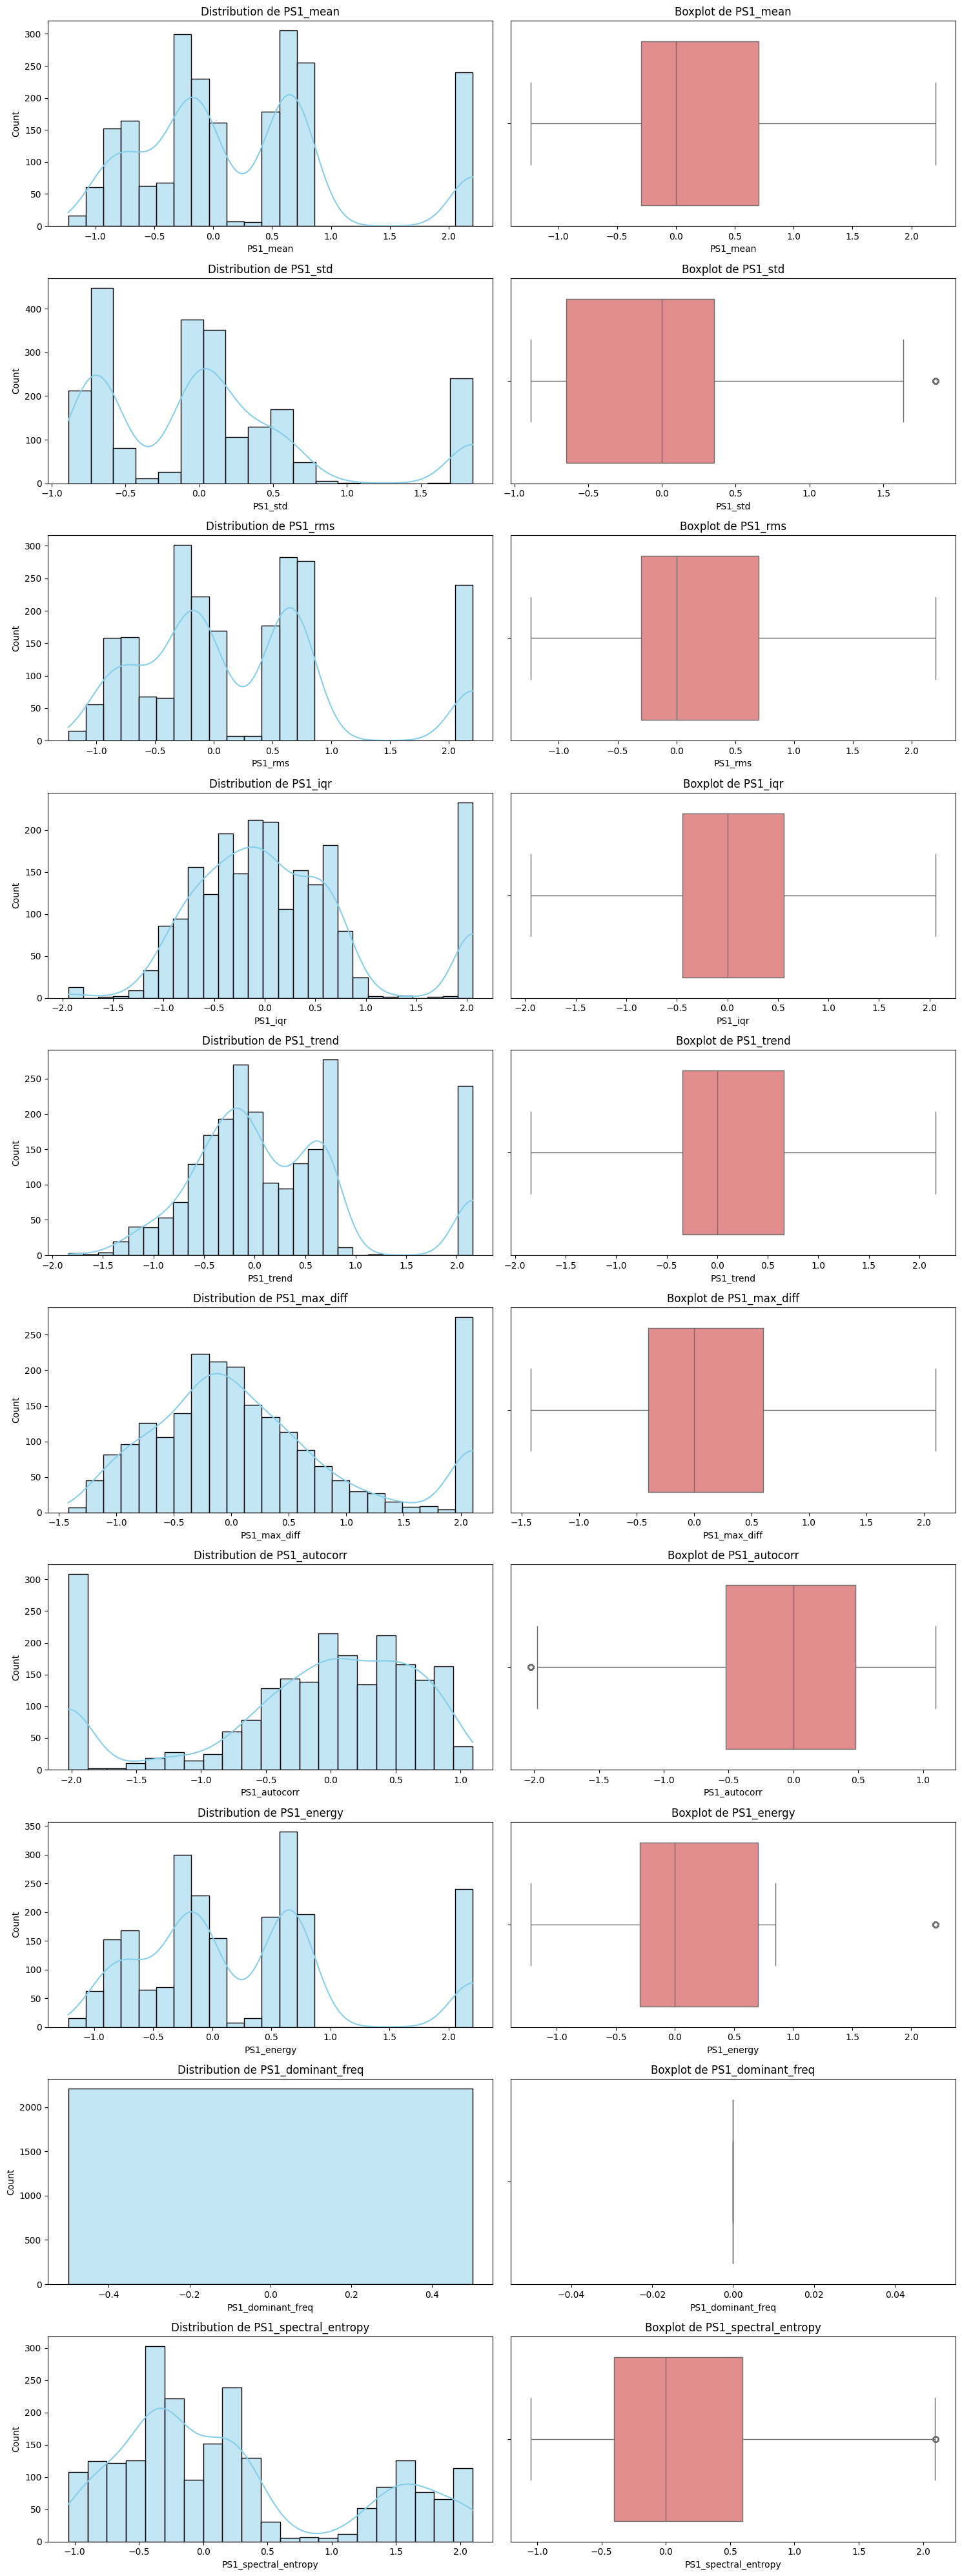

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Conversion de X_scaled en DataFrame pour faciliter la visualisation
X_final = pd.DataFrame(X_scaled, columns=X.columns)

# Sélection de 10 colonnes représentatives pour ne pas surcharger les graphiques
cols_to_plot = X_final.columns[:10]

# Création des graphiques
fig, axes = plt.subplots(nrows=len(cols_to_plot), ncols=2, figsize=(15, 4 * len(cols_to_plot)))

for i, col in enumerate(cols_to_plot):
    # Histogramme
    sns.histplot(X_final[col], kde=True, ax=axes[i, 0], color='skyblue')
    axes[i, 0].set_title(f'Distribution de {col}')
    
    # Boxplot
    sns.boxplot(x=X_final[col], ax=axes[i, 1], color='lightcoral')
    axes[i, 1].set_title(f'Boxplot de {col}')

plt.tight_layout()
plt.show()

## Vérification fonctionnelle du dataset (Sanity Check)
On s'assure qu'il ne reste aucune valeur manquante, infinie, et que la normalisation robuste a bien fonctionné.

In [36]:
def check_dataset_health(df):
    print("=== RAPPORT DE SANTÉ DU DATASET ===")
    
    # 1. Vérification des NaNs
    nas = df.isna().sum().sum()
    print(f"- Valeurs manquantes totales : {nas}")
    
    # 2. Vérification des valeurs infinies
    infs = np.isinf(df.values).sum()
    print(f"- Valeurs infinies totales : {infs}")
    
    # 3. Vérification de la normalisation (Moyenne des Médianes)
    # Avec RobustScaler, la médiane de chaque colonne doit être rigoureusement 0
    median_avg = df.median().mean()
    print(f"- Médiane moyenne du dataset : {median_avg:.4f} (Doit être proche de 0)")
    
    # 4. Vérification de l'échelle (IQR)
    # Avec RobustScaler, l'IQR de chaque colonne doit être 1
    q75, q25 = np.percentile(df, [75 ,25], axis=0)
    iqr_avg = (q75 - q25).mean()
    print(f"- IQR moyen du dataset : {iqr_avg:.4f} (Doit être proche de 1)")

    if nas == 0 and infs == 0 and abs(median_avg) < 0.1:
        print("\n✅ DATASET OPÉRATIONNEL : Prêt pour l'entraînement.")
    else:
        print("\n⚠️ ATTENTION : Des anomalies persistent dans les données.")

# Exécution du test
check_dataset_health(X_final)

=== RAPPORT DE SANTÉ DU DATASET ===
- Valeurs manquantes totales : 0
- Valeurs infinies totales : 0
- Médiane moyenne du dataset : 0.0000 (Doit être proche de 0)
- IQR moyen du dataset : 0.8986 (Doit être proche de 1)

✅ DATASET OPÉRATIONNEL : Prêt pour l'entraînement.


In [39]:
# 1. Reconstruction du DataFrame nettoyé
# On utilise les colonnes de X (après suppression des NaN) pour garder les noms des capteurs
X_final = pd.DataFrame(X_scaled, columns=X.columns)

# 2. Réintégration de la cible (valve_ok)
# .values est utilisé pour éviter les problèmes d'index si des lignes ont été supprimées
X_final['valve_ok'] = y.values

# 3. Création du dossier si nécessaire et sauvegarde
import os
os.makedirs("data/processed", exist_ok=True)

OUTPUT_PATH = "data/processed/dataset_cleaned.csv"
X_final.to_csv(OUTPUT_PATH, index=False)

print(f"✅ Succès : Dataset nettoyé sauvegardé dans {OUTPUT_PATH}")
print(f"Dimensions finales : {X_final.shape}")

✅ Succès : Dataset nettoyé sauvegardé dans data/processed/dataset_cleaned.csv
Dimensions finales : (2205, 139)
